In [23]:
%pip install matplotlib torch numpy scikit-learn pandas

  Using cached pandas-2.0.2-cp310-cp310-win_amd64.whl (10.7 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2021.1
    Uninstalling tzdata-2021.1:
      Successfully uninstalled tzdata-2021.1
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Dataset
from utils.modules_pbashivan import load_bashivan_data
#from utils.modules_pbashivan import get_subject_indices_kfcv

import numpy as np
import random

# Dataset and Dataloader
from torch.utils.data import TensorDataset, DataLoader
# Save arguments
import argparse

# Torch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#Sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import warnings

#from models.model_base import RecResNet
#from utils.utils import get_subject_data

warnings.simplefilter("ignore")


In [25]:
parser = argparse.ArgumentParser()
parser.add_argument('--dir_pretrain', type=str, default="outputs/recresnet", help='folder used by DNN')
parser.add_argument('--dir_resume', type=str, default="outputs/resume", help='folder for resume')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--epochs', type=int, default=30, help='number of epochs')
parser.add_argument('--seed', type=int, default=223, help='seed')
args = parser.parse_args("")

In [26]:
# set random seeds
np.random.seed(args.seed)
random.seed(args.seed)
#tf.set_random_seed(args.seed)
print("SEED:", args.seed)

SEED: 223


In [27]:
path = 'Dataset/'

In [28]:
# load data
X, y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=False,
                        size_image=24, visualize=False)


Loading data from Dataset/FeatureMat_timeWin.mat
Data loading complete. Shape is (2670, 1345)
Original data: (2670, 1344) (2670,)
Shape images (2670, 3, 7, 24, 24)


# Model

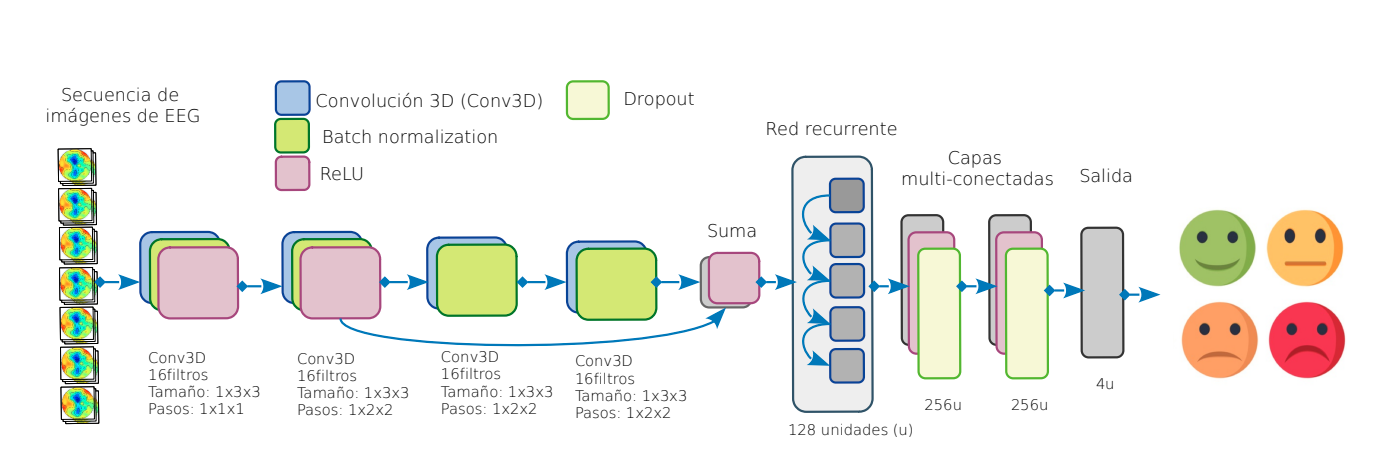

In [29]:

class RecResNet(nn.Module):
    '''
    Build the  Mean Basic model performing a classification with CNN 

    param input_image: list of EEG image [batch_size, n_window, n_channel, h, w]
    param n_classes: number of classes
    return x: output of the last layers after the log softmax
    '''
    def __init__(self, n_classes=4):
        super(RecResNet, self).__init__()

        self.num_layers = 1
        self.hidden_dim = 128

        # Layer 1
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='valid')
        self.bn1 = nn.BatchNorm3d(16, momentum=0.1)

        # Layer 2
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding='valid')
        self.bn2 = nn.BatchNorm3d(16, momentum=0.1)

        #  Residual block ->
        self.conv3 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same')
        self.bn3 = nn.BatchNorm3d(16, momentum=0.1)

        self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same')
        self.bn4 = nn.BatchNorm3d(16, momentum=0.1)

        # Capa Recurrente
        # [32x32 -> 3136]
        # [24x24 -> 1600]
        self.rnn = nn.GRU(input_size=1600, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=0.5)

        #
        self.fc1 = nn.Linear(128, 128)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 128)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, n_classes)

    
    def forward(self, x):
        # Layer 1
        x = F.tanh(self.bn1(self.conv1(x)))

        # Layer 2
        x = F.relu(self.bn2(self.conv2(x)))

        # Residual block
        o = F.relu(self.bn3(self.conv3(x)))
        o = self.bn4(self.conv4(o))
        r = F.relu(x + o)

        # swap axes
        r = torch.swapaxes(r, 1, 2)
        # reshape
        r = torch.reshape(r, (r.shape[0], r.shape[1], r.shape[2] * r.shape[3] * r.shape[4]))
        # RNN
        out, _ = self.rnn(r)

        # redimensionar las salidas en el forma (batch_size, seq_length, hidden_size)
        # tal que esto pueda ser manejable por la capa de salida
        feats_rnn = out[:, -1]

        feats = F.relu(self.fc1(feats_rnn))
        feats = self.drop1(feats)
        feats = F.relu(self.fc2(feats))
        feats = self.drop2(feats)

        out = self.fc3(feats)

        return out

In [30]:
X.shape

(2670, 3, 7, 24, 24)

In [31]:
# Probamos el modelo:
x_mod = torch.tensor(X[:16,:,:,:,:])
print(x_mod.shape)

torch.Size([16, 3, 7, 24, 24])


In [32]:
prueba_modelo = RecResNet()

In [33]:
prueba_modelo(x_mod.float())

tensor([[-0.0884,  0.0940,  0.0099,  0.0082],
        [-0.0657,  0.0935, -0.0580,  0.1508],
        [ 0.0182,  0.3162,  0.0202,  0.0918],
        [ 0.0037,  0.2244, -0.4654, -0.3432],
        [ 0.0364,  0.1017, -0.1532,  0.1913],
        [ 0.0258,  0.0063,  0.0644,  0.1828],
        [ 0.1422,  0.0890, -0.0897, -0.0774],
        [ 0.1177, -0.0079,  0.0970, -0.0307],
        [ 0.1678,  0.0188, -0.0337, -0.1203],
        [ 0.0936,  0.1663, -0.1555, -0.1853],
        [-0.0264,  0.0076, -0.0283,  0.0254],
        [ 0.0700, -0.0136, -0.1071, -0.0324],
        [ 0.1604, -0.0117,  0.1589, -0.1209],
        [ 0.0108, -0.0465,  0.0464,  0.0561],
        [ 0.2125,  0.0238,  0.2609,  0.3821],
        [-0.0060,  0.1236,  0.0641,  0.0292]], grad_fn=<AddmmBackward0>)

In [34]:
prueba_modelo(x_mod.float()).shape

torch.Size([16, 4])

# Train

## Evaluation function

In [35]:
def test(model, test_loader):
    start_test = True
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # get batch data
            samples = data[0].float() #.cuda()
            labels = data[1].long() #.cuda()

            # Get features and predictions
            preds = model(samples)
            # probabilidad máxima
            predictions = preds.data.max(1)[1]

            if start_test:
                y_pred = predictions.cpu().numpy()
                y_true = labels.data.cpu().numpy()
                start_test = False
            else:
                y_pred = np.concatenate((y_pred, predictions.cpu().numpy()), 0)
                y_true = np.concatenate((y_true, labels.data.cpu().numpy()), 0)

        # Binarize ytest with shape (n_samples, n_classes)
        labels = np.unique(y_true)
        ytest = label_binarize(y_true, classes=labels)
        ypreds = label_binarize(y_pred, classes=labels)

        # compute utils
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(ytest, ypreds, average='macro', multi_class='ovr')


    return acc, f1, auc

### K-Fold cross validation

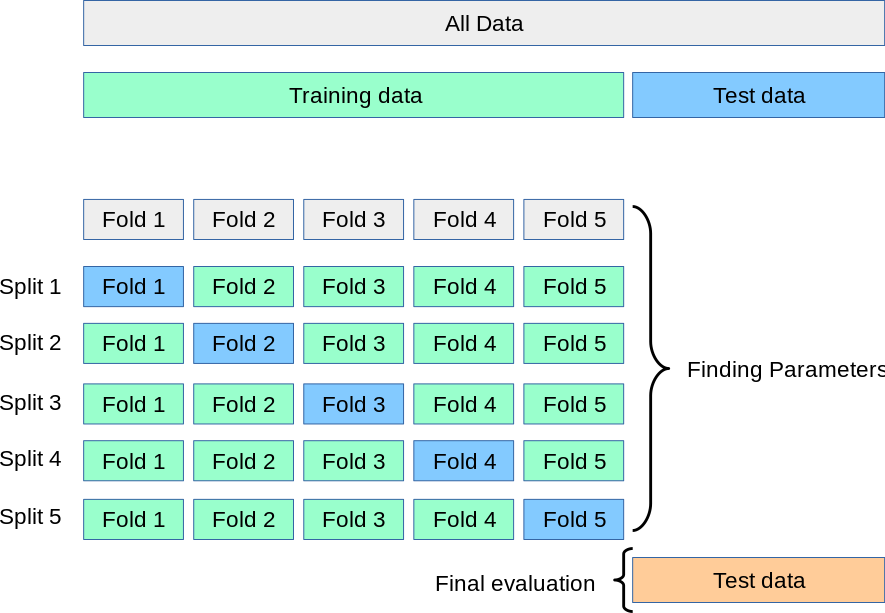

In [36]:
def get_subject_indices_kfcv(id_subjects):

    subject_indices = []
    for id in np.unique(id_subjects): # recorre el total de sujetos.
        # print(i)
        ts = id_subjects == id  # return array with True where the index i is equal to indices in subjNumbers
        # after convert this array of numbers.
        ts = np.squeeze(np.nonzero(ts))  # conver ts with trues to array with numbers
        np.random.shuffle(ts)
        subject_indices.append(ts)

    return subject_indices

In [37]:
def kfcv(X, Y, subjects, args):
    """
        K-fold Cross Validation

        Params
            X: dataset containing all subject samples
            Y: dataset containing all subject labels
            subjects: dataset containing pairs between sample indexes and subjects
            args: hyper-parameters to train Custom Domain Adaptation.
    """

    # Extract pairs between indexes and subjects
    subject_indices = get_subject_indices_kfcv(subjects)

    # Iterate over fold_pairs
    for foldNum, fold_indices in enumerate(subject_indices):
        print('Beginning fold {0} out of {1}'.format(foldNum + 1, len(subject_indices)))

        # get data from subject according to fold indices
        x = X[fold_indices]
        y = np.squeeze(Y[fold_indices]).astype(np.int32)
        y_classes = np.unique(y)

        skf = StratifiedKFold(n_splits=5)
        skf.get_n_splits(x, y)

        list_metrics_clsf = []

        for i, (train_index, test_index) in enumerate(skf.split(x, y)):

            x_train, y_train = x[train_index], y[train_index]
            x_test, y_test = x[test_index], y[test_index]



            # data shape
            print("x_train-shape:", x_train.shape, "y_train-shape:", y_train.shape)
            print("x_test-shape:", x_test.shape, "y_test-shape:", y_test.shape)
            print("classes:", y_classes)


            # [NUMPY TO TENSOR]
            Sx_tensor = torch.tensor(x_train)
            Sy_tensor = torch.tensor(y_train)
            Tx_tensor = torch.tensor(x_test)
            Ty_tensor = torch.tensor(y_test)

            # [CONTAINERS]
            # create container for source labeled data
            source = TensorDataset(Sx_tensor, Sy_tensor)
            # create container for labeled target data
            target = TensorDataset(Tx_tensor, Ty_tensor)

            # [BUILD DATA LOADERS]
            # target
            source_loader = DataLoader(source, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
            target_loader = DataLoader(target, batch_size=20, shuffle=False, num_workers=4)

            # [Build Model]
            model = RecResNet(n_classes=4) #.cuda()

            # [Optimizers]
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.005)
            # [Classification loss]
            criterion = nn.CrossEntropyLoss() #.cuda()



            for epoch in range(args.epochs):

                # iterator
                iter_train = iter(source_loader)
                list_loss = []

                for c in range(len(source_loader)):
                    # get batch
                    samples, labels = next(iter_train)
                    samples = samples.float() #.cuda()
                    labels = labels.long() #.cuda()

                    model.train(True)

                    # get features and labels for source and target domain
                    outputs = model(samples)
                    cls_loss = criterion(outputs, labels)

                    # reset gradients
                    optimizer.zero_grad()

                    # compute gradients
                    cls_loss.backward()

                    # update weights
                    optimizer.step()

                    # append loss
                    list_loss.append(cls_loss.cpu().detach().numpy())

                # evaluation
                model.eval()

                # [DFN | CNN]
                acc_test, f1_test, auc_test = test(model, target_loader)
                avg_loss = np.array(list_loss).mean()
                print('Epoch: %d loss: %4f Acc: %.4f  F1-score: %.4f  AUC: %.4f' % (epoch+1, avg_loss, acc_test, f1_test, auc_test))

            print("\n")
            # add to list
            list_metrics_clsf.append([acc_test, f1_test, auc_test, foldNum+1])

        # To np array
        list_metrics_clsf = np.array(list_metrics_clsf)

        # Save Classification Metrics
        save_file = args.dir_resume + "/kfcv-results.csv"
        f = open(save_file, 'ab')
        np.savetxt(f, list_metrics_clsf, delimiter=",", fmt='%0.4f')
        f.close()

In [ ]:
kfcv(X, y, subjects, args)

Beginning fold 1 out of 13
x_train-shape: (148, 3, 7, 24, 24) y_train-shape: (148,)
x_test-shape: (37, 3, 7, 24, 24) y_test-shape: (37,)
classes: [0 1 2 3]
Epoch: 1 loss: 1.354816 Acc: 0.5135  F1-score: 0.3523  AUC: 0.6488
Epoch: 2 loss: 1.220183 Acc: 0.5676  F1-score: 0.3824  AUC: 0.6786
Epoch: 3 loss: 1.081516 Acc: 0.7838  F1-score: 0.6567  AUC: 0.8249
Epoch: 4 loss: 0.990122 Acc: 0.5405  F1-score: 0.3612  AUC: 0.6597
Epoch: 5 loss: 0.914266 Acc: 0.5405  F1-score: 0.3612  AUC: 0.6597
Epoch: 6 loss: 0.848083 Acc: 0.5405  F1-score: 0.3612  AUC: 0.6597
Epoch: 7 loss: 0.737025 Acc: 0.5676  F1-score: 0.3824  AUC: 0.6786
Epoch: 8 loss: 0.610264 Acc: 0.5676  F1-score: 0.3824  AUC: 0.6786
Epoch: 9 loss: 0.517343 Acc: 0.6486  F1-score: 0.5452  AUC: 0.7455
Epoch: 10 loss: 0.477079 Acc: 0.7027  F1-score: 0.6135  AUC: 0.7902
Epoch: 11 loss: 0.317289 Acc: 0.7027  F1-score: 0.6141  AUC: 0.7979
Epoch: 12 loss: 0.293482 Acc: 0.7297  F1-score: 0.6415  AUC: 0.8125
Epoch: 13 loss: 0.246721 Acc: 1.0000 

## Open results in csv

In [ ]:
import pandas as pd

df = pd.read_csv(args.dir_resume + "/kfcv-results.csv")
print(df.to_string()) 